# Sentiment Difference Visualizations

In [1]:
import statistics as stat
import numpy as np
import pandas as pd
import csv as csv
import matplotlib.pyplot as mpl
import os
from tqdm import tqdm

pwd = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/csv_data/"

epoch_day = 86400000        # accounting for milliseconds

In [2]:
with open(os.path.join(pwd, "from_inflection.csv"), 'r', encoding='utf-8') as infile:
    a_df = pd.read_csv(infile, header=0)
    from_df = a_df.fillna(0)[(a_df.pre_count.values > 5) & (a_df.post_count.values > 5)]
with open(os.path.join(pwd, "to_inflection.csv"), 'r', encoding='utf-8') as infile:
    b_df = pd.read_csv(infile, header=0)
    to_df = b_df.fillna(0)[(b_df.pre_count.values > 5) & (b_df.post_count.values > 5)]
with open(os.path.join(pwd, "overall_inflection.csv"), 'r', encoding='utf-8') as infile:
    c_df = pd.read_csv(infile, header=0)
    overall_df = c_df.fillna(0)[(c_df.pre_count.values > 5) & (c_df.post_count.values > 5)]

In [3]:
em = 12
mpl.rcParams['figure.figsize'] = [9, 4]
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['font.family'] = "serif"
mpl.rcParams['font.size'] = 8

In [4]:
print(f"FROM: {len(a_df)} entries \t\t TO: {len(b_df)} entries \t\t OVERALL: {len(c_df)} entries ")
print(f"FROM: {len(from_df)} valid entries \t TO: {len(to_df)} valid entries \t OVERALL: {len(overall_df)} valid entries ")

FROM: 240034 entries 		 TO: 246331 entries 		 OVERALL: 274559 entries 
FROM: 47466 valid entries 	 TO: 47385 valid entries 	 OVERALL: 38688 valid entries 


### Difference Plots

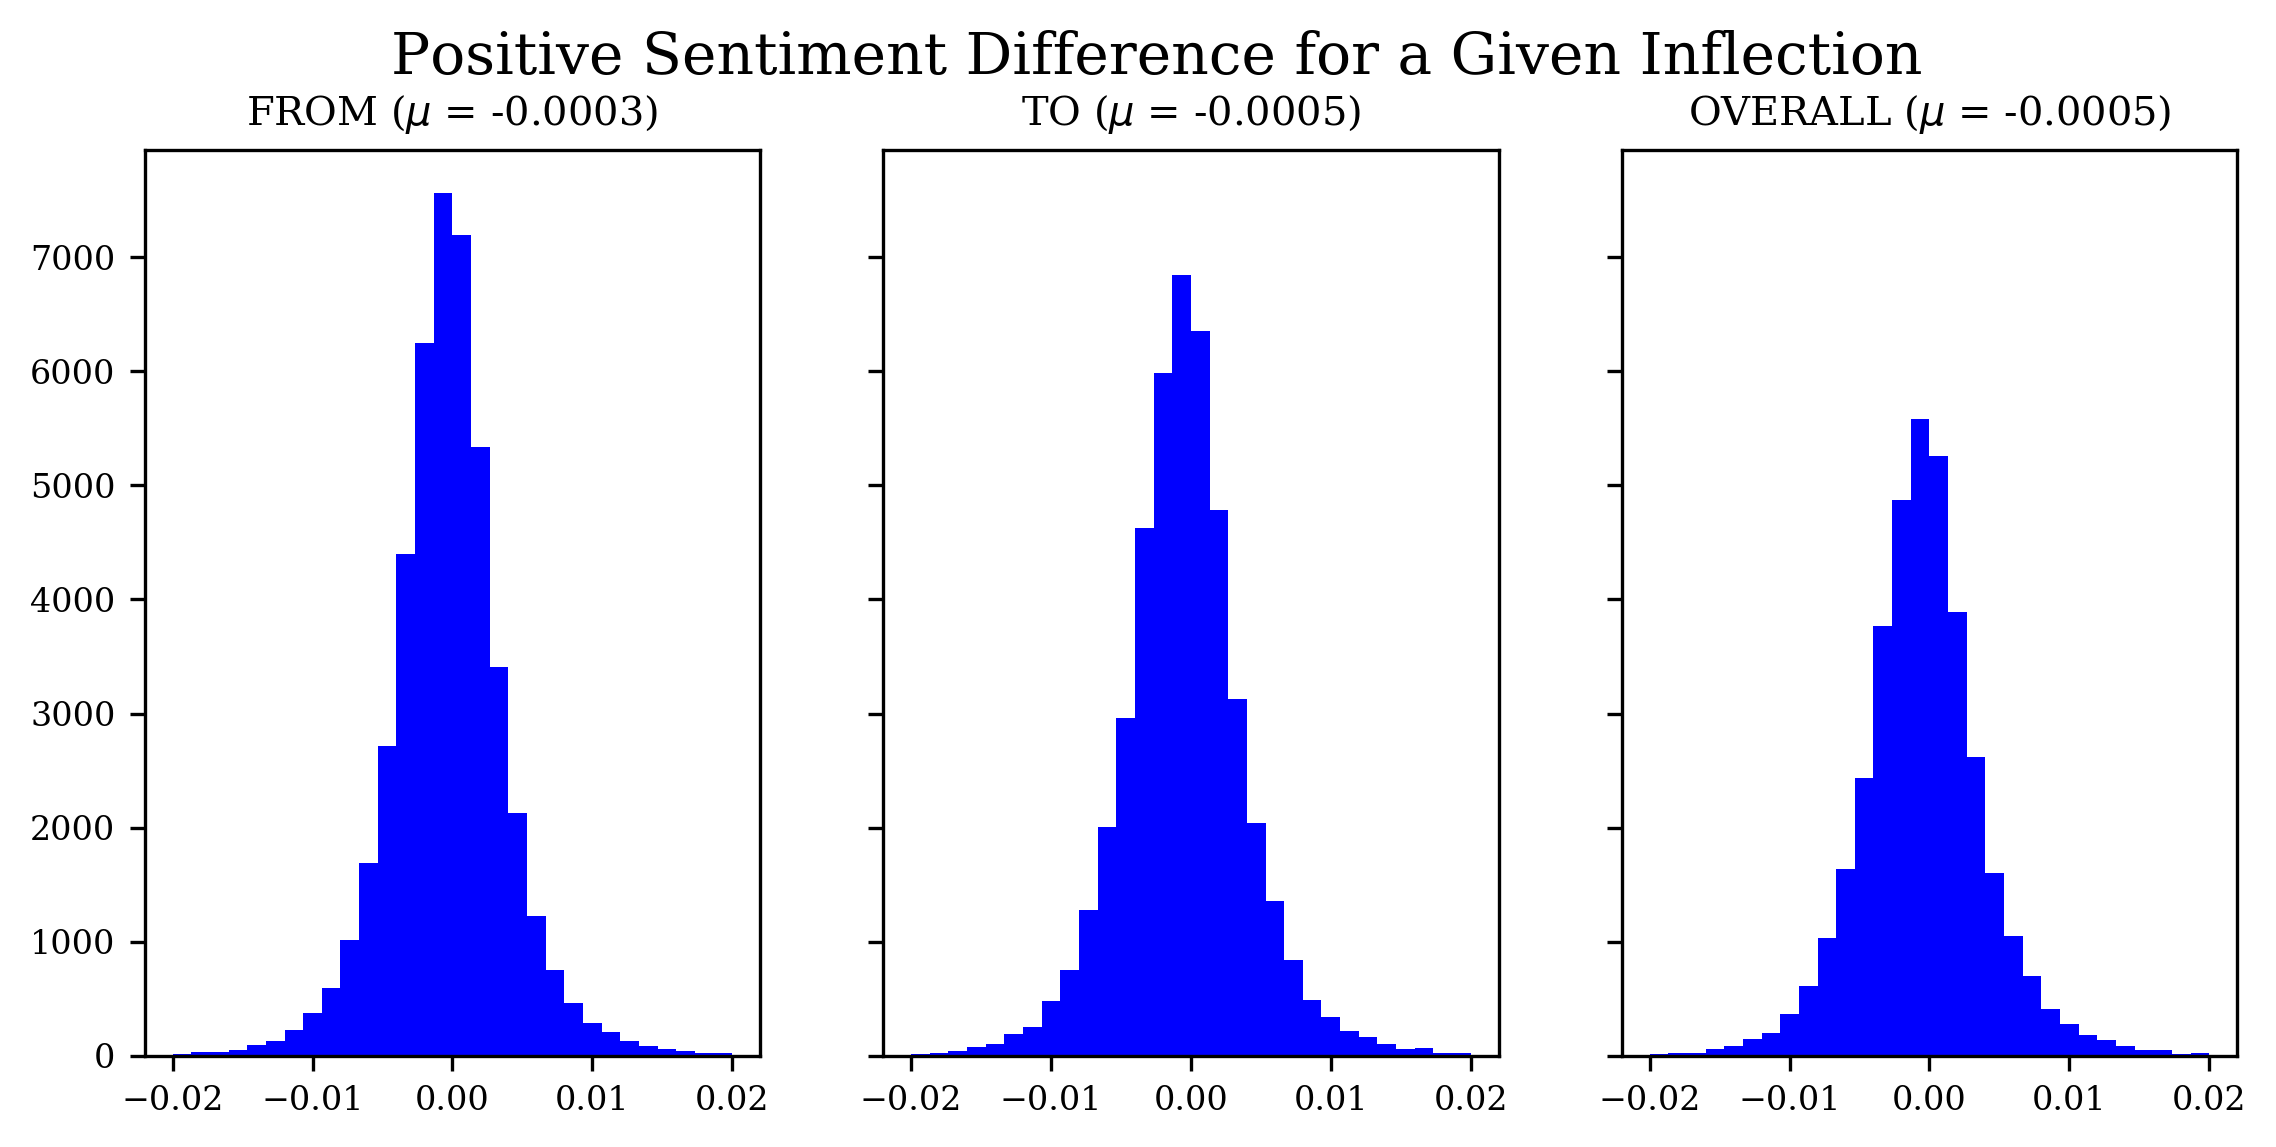

In [14]:
fig, axs = mpl.subplots(1, 3, sharey=True)

axs[0].hist(from_df.diff_pos, bins=30, range=(-.02, .02), color = 'b')
axs[0].set_title(f"FROM ($\mu$ = {round(stat.mean(from_df.diff_pos.values), 4)})")
axs[1].hist(to_df.diff_pos, bins=30, range=(-.02, .02), color = 'b')
axs[1].set_title(f"TO ($\mu$ = {round(stat.mean(to_df.diff_pos.values), 4)})")
axs[2].hist(overall_df.diff_pos, bins=30, range=(-.02, .02), color = 'b')
axs[2].set_title(f"OVERALL ($\mu$ = {round(stat.mean(overall_df.diff_pos.values), 4)})")

fig.suptitle("Positive Sentiment Difference for a Given Inflection", fontsize=em+2)

mpl.show()

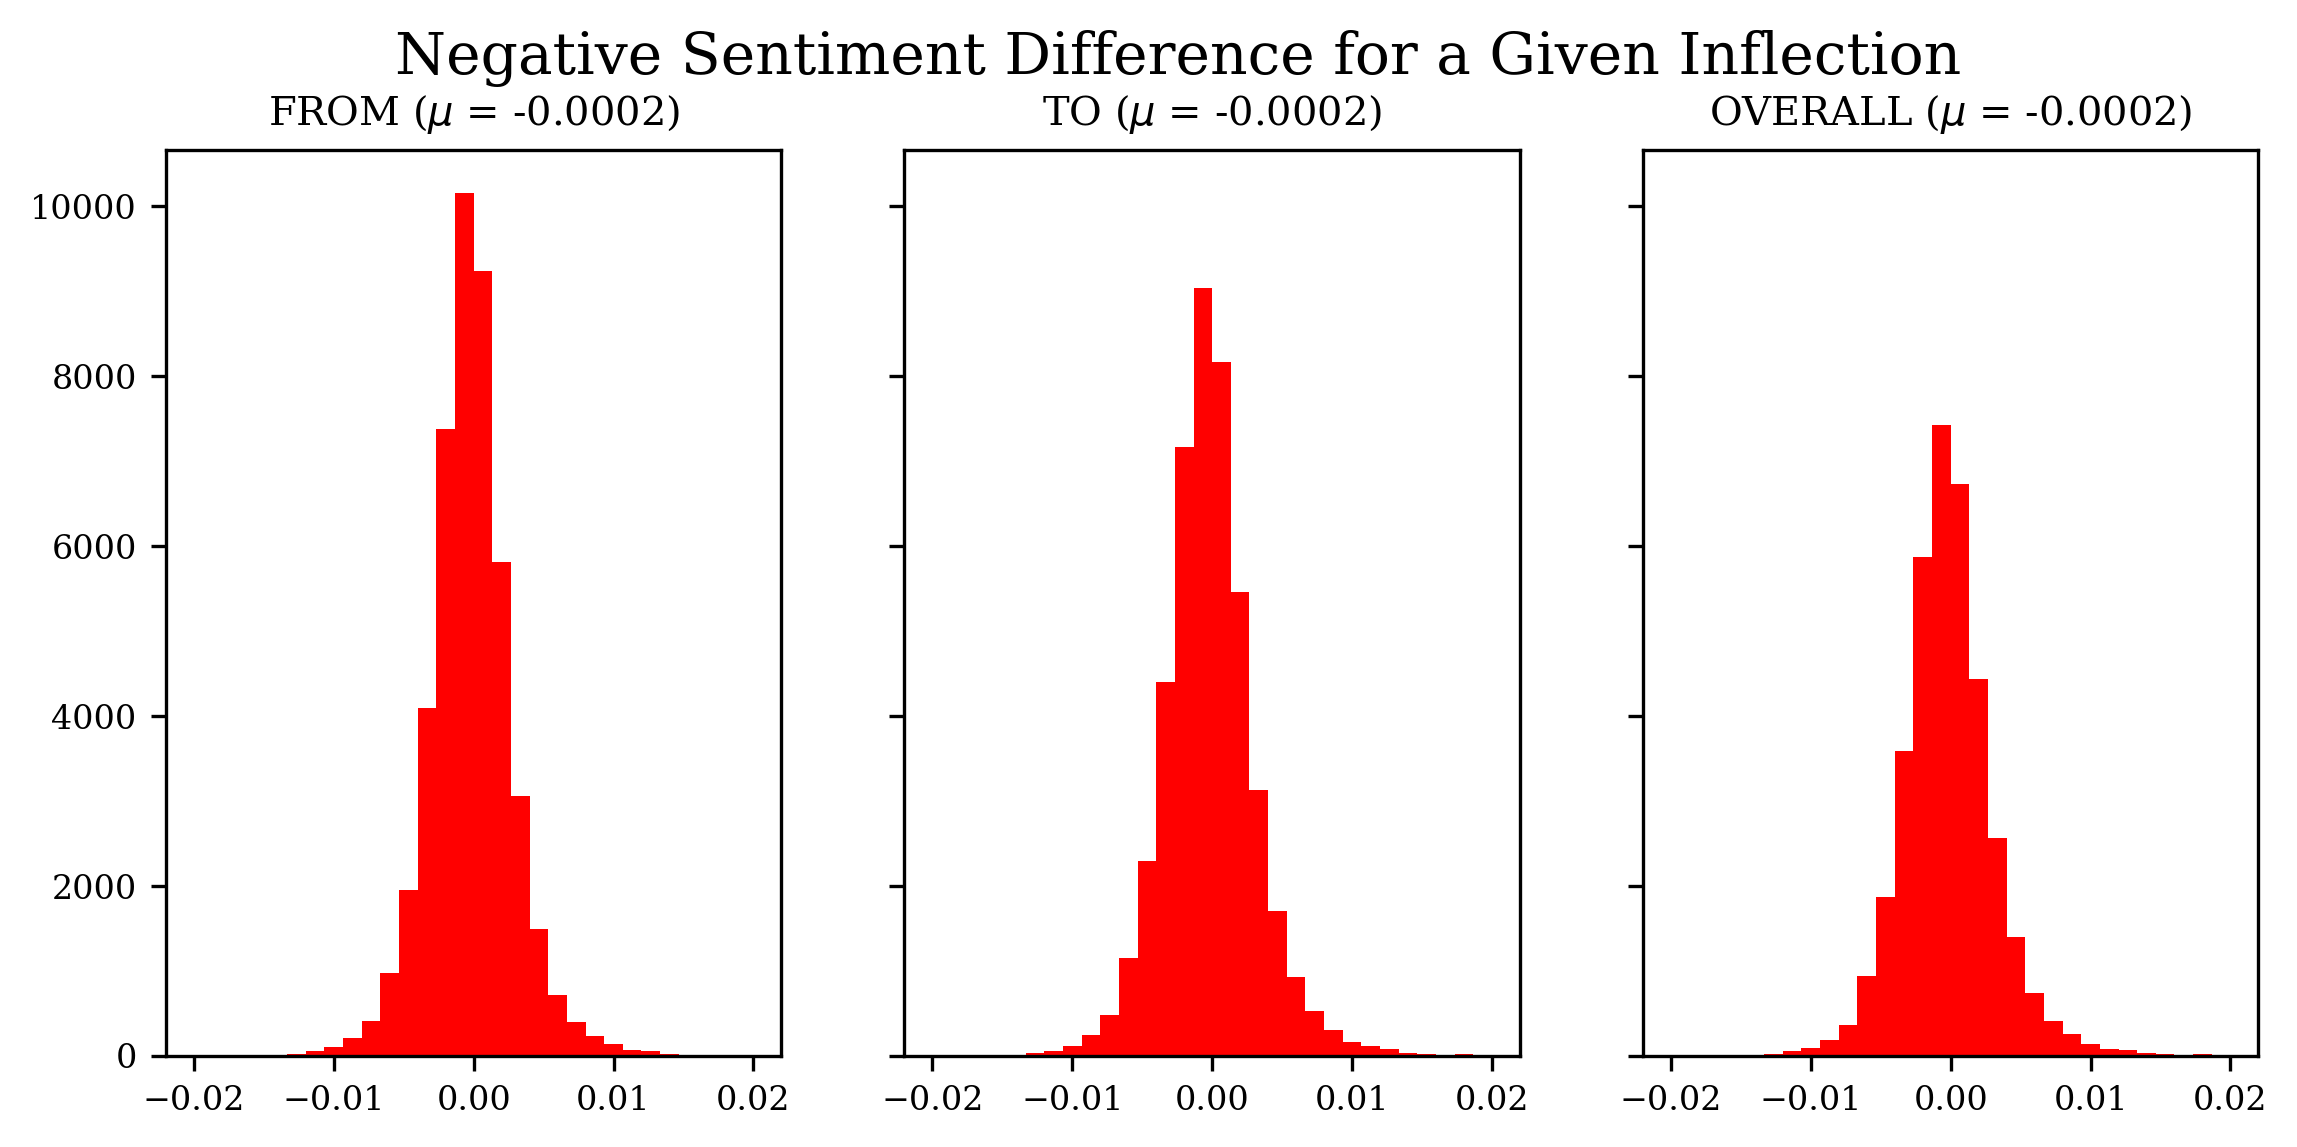

In [15]:
fig, axs = mpl.subplots(1, 3, sharey=True)

axs[0].hist(from_df.diff_neg, bins=30, range=(-.02, .02), color = 'r')
axs[0].set_title(f"FROM ($\mu$ = {round(stat.mean(from_df.diff_neg.values), 4)})")
axs[1].hist(to_df.diff_neg, bins=30, range=(-.02, .02), color = 'r')
axs[1].set_title(f"TO ($\mu$ = {round(stat.mean(to_df.diff_neg.values), 4)})")
axs[2].hist(overall_df.diff_neg, bins=30, range=(-.02, .02), color = 'r')
axs[2].set_title(f"OVERALL ($\mu$ = {round(stat.mean(overall_df.diff_neg.values), 4)})")

fig.suptitle("Negative Sentiment Difference for a Given Inflection", fontsize=em+2)

mpl.show()

### Fitting the Regression
Fit this to pre_pos, pre_count, the post_pre_count_ratio, tenure, pre_all_patient_author_ratio, and initiator_ratio.

In [5]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [15]:
dat = overall_df.copy()
dat.head()

,user_id,peer_id,created_at,pre_count,post_count,pre_pos,post_pos,diff_pos,pre_neg,post_neg,diff_neg,pre_pa_count,post_pa_count,is_init
10,19,3320.0,1.125421e+12,39,7,0.011337,0.009129,0.002208,0.003675,0.000000,0.003675,23,2,0
11,20,55854.0,1.375489e+12,24,143,0.004933,0.007828,-0.002896,0.004886,0.005778,-0.000892,1,9,0
13,22,22.0,1.128602e+12,11,9,0.008415,0.007849,0.000566,0.002078,0.005353,-0.003274,0,1,1
14,27,344749.0,1.309366e+12,14,9,0.003503,0.010161,-0.006659,0.006341,0.004984,0.001357,10,5,0
25,43,415094.0,1.464550e+12,9,180,0.016944,0.011127,0.005817,0.000000,0.003855,-0.003855,0,27,1


In [16]:
with open(os.path.join(pwd, "dynamic_auth.csv"), 'r', encoding='utf-8') as auths:
    authors = pd.read_csv(auths, usecols=[0,2,3], names = ['user_id', 'first', 'last'])
    authors['tenure'] = ((authors["last"] - authors["first"]) / epoch_day)
    authors = authors[["user_id", "tenure"]]
    dat = pd.merge(dat, authors, on="user_id", how="left")

In [18]:
dat["pre_pred_prop"] = np.divide(dat["pre_pa_count"], dat["pre_count"])
dat["inf_count_prop"] = np.divide(dat["post_count"], dat["pre_count"])
dat["single_author"] = [int(x > .9 or x < .1) for x in dat["pre_pred_prop"]]
dat["patient_author"] = [int(x > .9) for x in dat["pre_pred_prop"]]
dat.head()

,user_id,peer_id,created_at,pre_count,post_count,pre_pos,post_pos,diff_pos,pre_neg,post_neg,diff_neg,pre_pa_count,post_pa_count,is_init,tenure,pre_pred_prop,inf_count_prop,single_author,patient_author
0,19,3320.0,1.125421e+12,39,7,0.011337,0.009129,0.002208,0.003675,0.000000,0.003675,23,2,0,90.217812,0.589744,0.179487,0,0
1,20,55854.0,1.375489e+12,24,143,0.004933,0.007828,-0.002896,0.004886,0.005778,-0.000892,1,9,0,2984.058553,0.041667,5.958333,1,0
2,22,22.0,1.128602e+12,11,9,0.008415,0.007849,0.000566,0.002078,0.005353,-0.003274,0,1,1,151.305440,0.000000,0.818182,1,0
3,27,344749.0,1.309366e+12,14,9,0.003503,0.010161,-0.006659,0.006341,0.004984,0.001357,10,5,0,2219.199769,0.714286,0.642857,0,0
4,43,415094.0,1.464550e+12,9,180,0.016944,0.011127,0.005817,0.000000,0.003855,-0.003855,0,27,1,4015.250000,0.000000,20.000000,1,0


In [27]:
results = smf.ols('post_pos ~ pre_pos + pre_count + pre_pa_count + is_init + tenure + pre_pred_prop + inf_count_prop', data=dat).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               post_pos   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     1096.
Date:                Sat, 20 Apr 2019   Prob (F-statistic):               0.00
Time:                        21:27:49   Log-Likelihood:             1.6427e+05
No. Observations:               38688   AIC:                        -3.285e+05
Df Residuals:                   38680   BIC:                        -3.285e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0067   4.73e-05    140.

In [19]:
corr = dat.corr()
corr = corr.round(2)
corr.style.apply(lambda x: ["background-color: yellow" if abs(v) > .1 else "" for v in x], axis = 1)

,user_id,peer_id,created_at,pre_count,post_count,pre_pos,post_pos,diff_pos,pre_neg,post_neg,diff_neg,pre_pa_count,post_pa_count,is_init,tenure,pre_pred_prop,inf_count_prop,single_author,patient_author
user_id,1,0.79,0.59,-0.07,-0.16,0.06,-0,0.06,0.05,0.01,0.04,0,-0.06,0.08,-0.02,0.09,-0.12,0.02,0.12
peer_id,0.79,1,0.49,-0,-0.14,0.05,0,0.05,0.04,0.01,0.03,0.04,-0.05,0.29,-0.02,0.1,-0.12,-0,0.12
created_at,0.59,0.49,1,0.06,0.15,0.04,-0.03,0.06,0.05,0.04,0.02,0.07,0.11,0.05,0.04,0.09,0.12,-0,0.11
pre_count,-0.07,-0,0.06,1,0.1,0.01,-0.03,0.03,0.04,0.03,0.02,0.61,0.1,0.1,0.02,0.05,-0.15,-0.02,0.03
post_count,-0.16,-0.14,0.15,0.1,1,-0.04,-0.05,0.01,-0,0.03,-0.03,0.05,0.62,-0.04,0.04,-0.03,0.8,-0.01,-0.03
pre_pos,0.06,0.05,0.04,0.01,-0.04,1,0.4,0.66,0.13,0.07,0.07,0.04,0.02,0.03,0,0.06,-0.04,-0.03,0.04
post_pos,-0,0,-0.03,-0.03,-0.05,0.4,1,-0.42,0.07,0.13,-0.04,0.01,-0,0.02,-0,0.03,-0.03,-0.02,0.02
diff_pos,0.06,0.05,0.06,0.03,0.01,0.66,-0.42,1,0.07,-0.04,0.1,0.04,0.02,0.01,0,0.04,-0.01,-0.02,0.02
pre_neg,0.05,0.04,0.05,0.04,-0,0.13,0.07,0.07,1,0.37,0.69,0.08,0.05,0.03,0,0.11,-0.03,-0.01,0.1
post_neg,0.01,0.01,0.04,0.03,0.03,0.07,0.13,-0.04,0.37,1,-0.42,0.08,0.08,0.03,0.01,0.12,0.02,-0.03,0.1
